In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
# imports
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp
from collections import defaultdict
from tqdm import tqdm

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent.parent
sys.path.append(str(parent_dir))

# Import necessary modules
from src.utils_plot import plot_loss_and_all_solution
from src.load_save import load_run_history
from src.transfer_learning import compute_H_and_dH_dt, compute_M_inv, compute_force_term
from src.nonlinear_transfer_learning import solve_perturbation_TL

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [5]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Fri Jan 12 15:46:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              N/A / ERR! |   1969MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

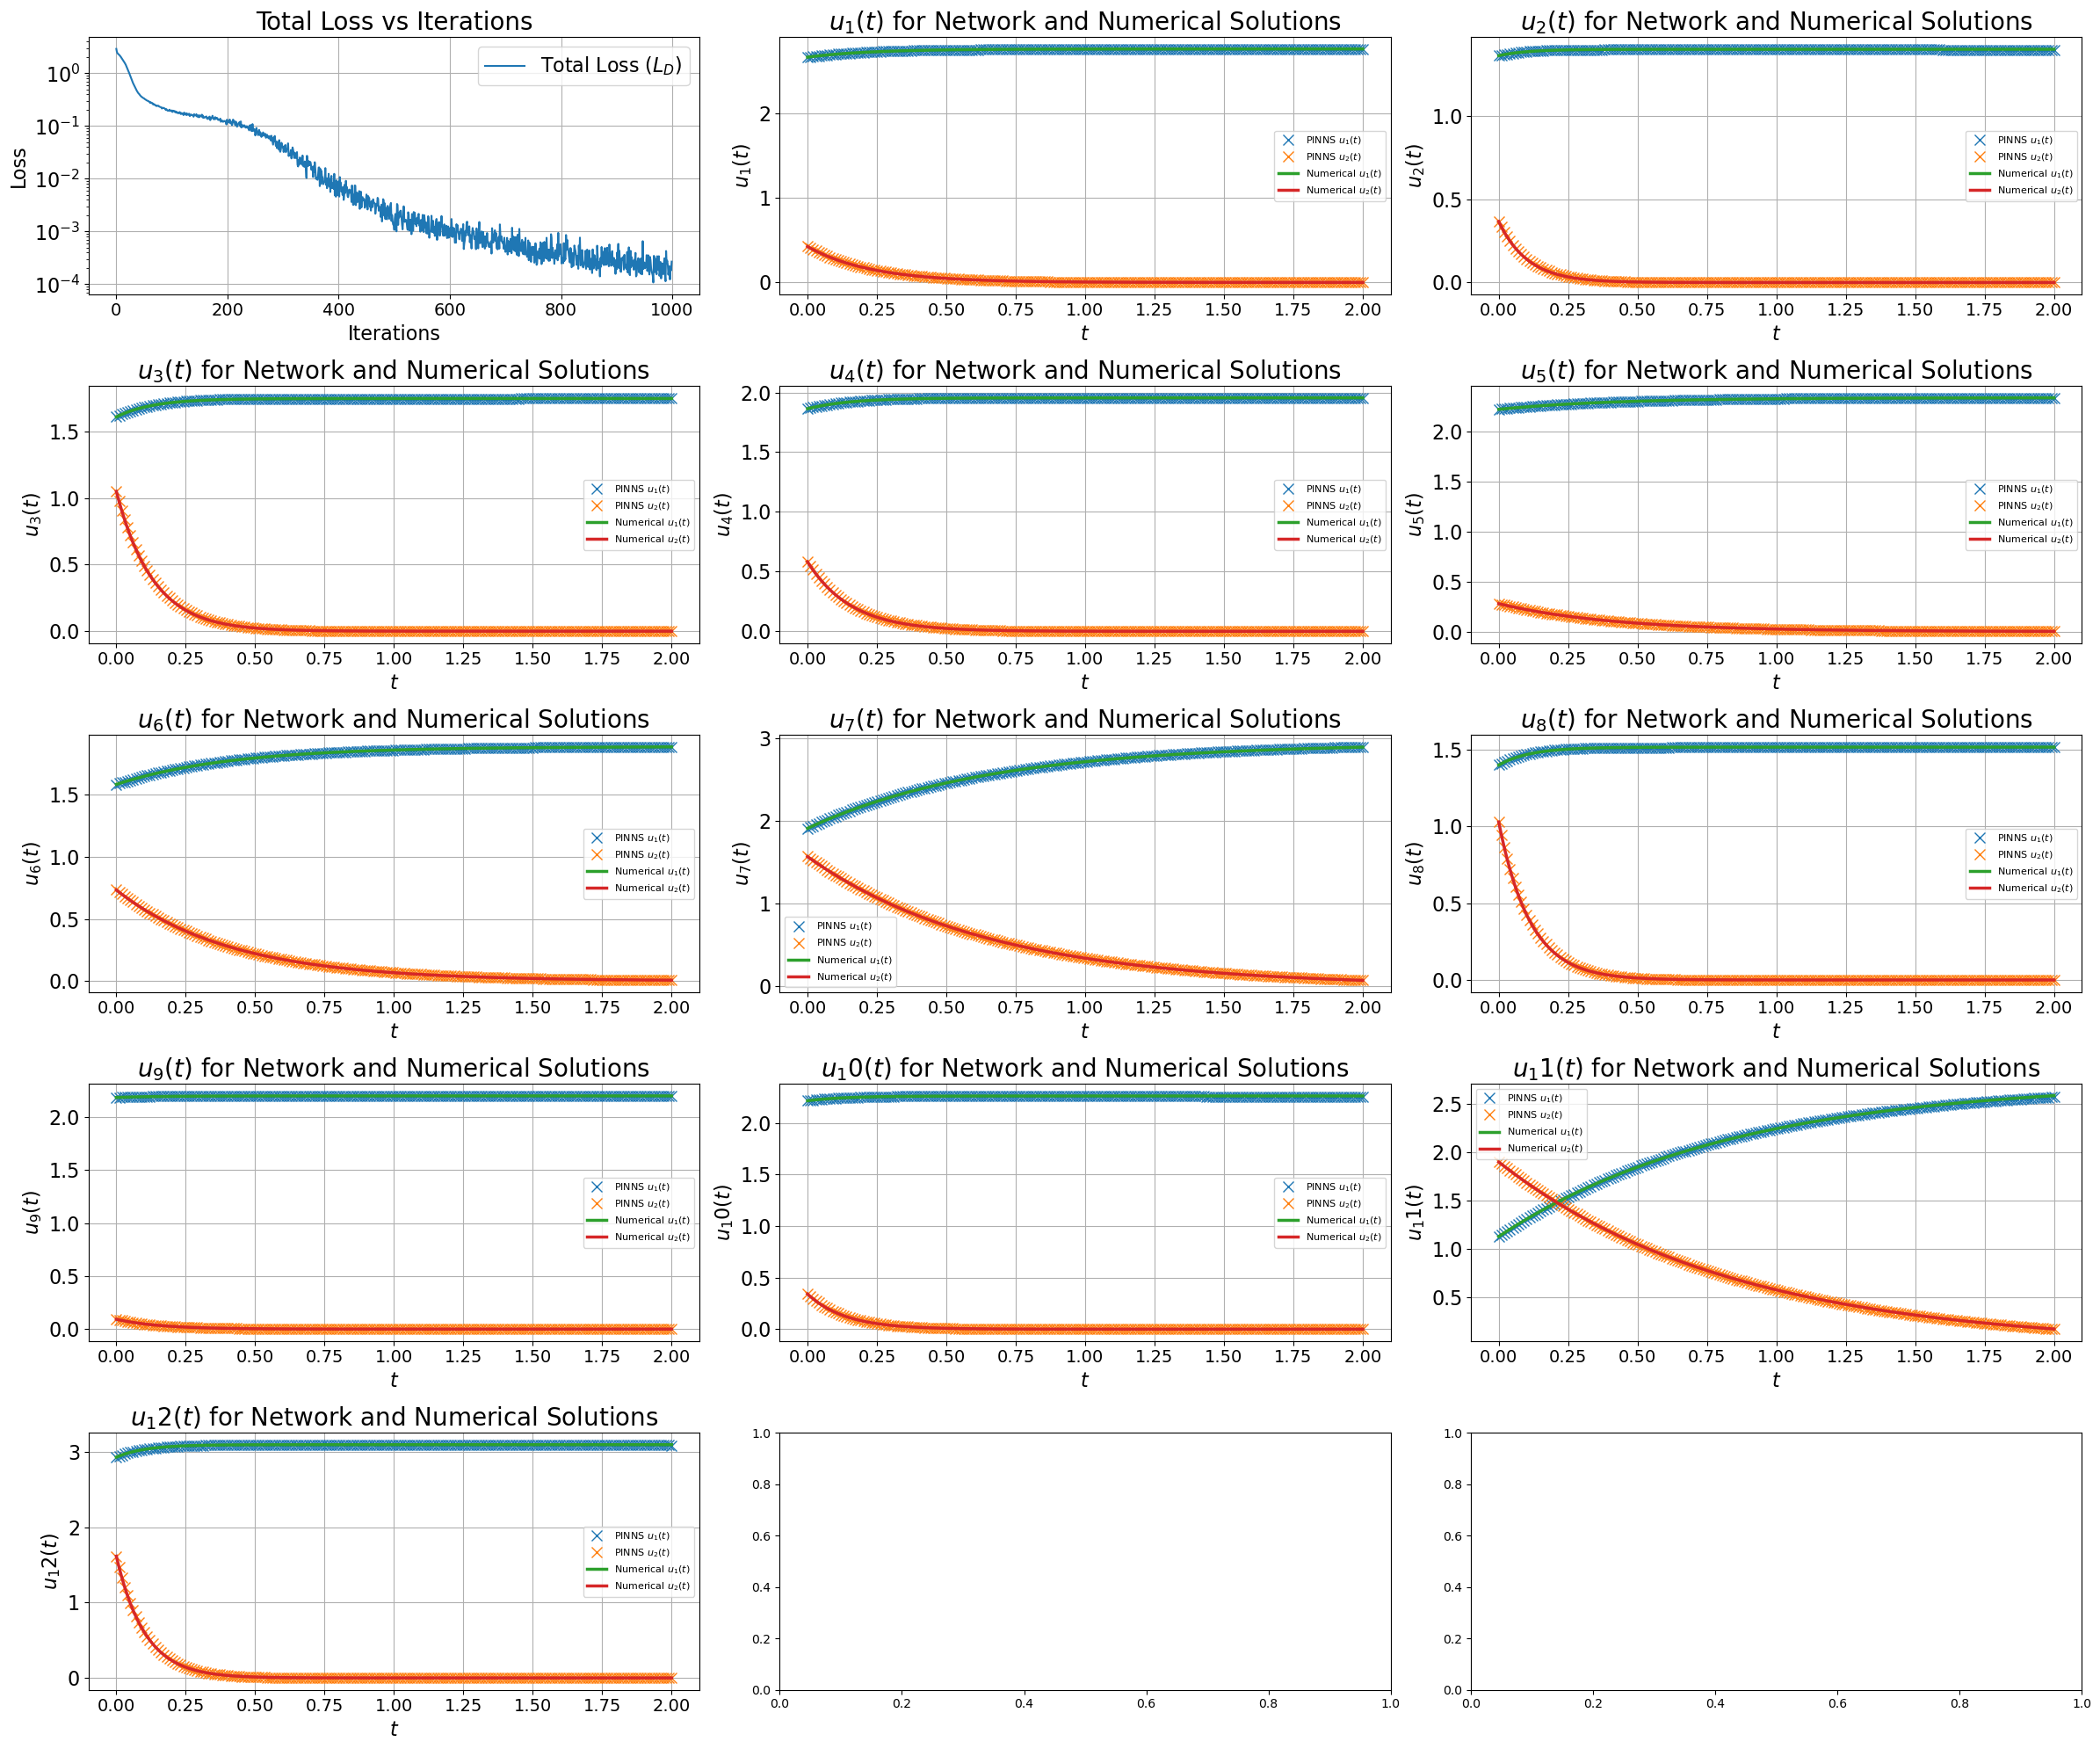

In [6]:
file_name = "inference_1121512"
equation_name = "nonlinear_medium"

trained_model, \
x_range, \
iterations, \
hid_lay, \
num_equations, \
num_heads, \
loss_hist, \
alpha_list, \
A_list, \
IC_list, \
force_list = load_run_history(equation_name, file_name, dev, prev=False)

# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[0., -1.], [0., alpha]], device=dev).double() 


plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)

In [7]:
# training IC (random or not)
def random_IC(x_bound=[1, 3], y_bound=[0, 2]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)

# training force (random or not)
def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = -np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev)

# Transfer learning to nonlinear equation

In [8]:
# forward pass to extract H, H0 and dH/dt
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)
H = H.double()
H_0 = H_0.double()
dH_dt_new = dH_dt_new.double()
t_eval = t_eval.double()

Time to compute H and dH_dt:  2.090 seconds


In [9]:
# Non linear equation to solve

alpha_transfer = 50; beta = 0.05

domain = (x_range[0], x_range[1]);
A_transfer = get_A(alpha=alpha_transfer)
IC_transfer = torch.tensor([[1.], [2.]], device=dev).double()
force_transfer = torch.tensor([[0.], [0.]], device=dev).double()

def numerical_non_linear_solution(alpha, beta, u0, domain, t_eval, method="Radau", r_tol= 1e-8):
  def F(t, y):
    return [-alpha*y[0]+ beta*y[1]**2,
            y[0] - beta*y[1]**2 + 1]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval, method=method, r_tol=r_tol)
  return solution

r_tol = 1e-4
numerical_sol_fct_radau = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                    method="Radau", r_tol=r_tol).y

numerical_sol_fct_rk45 = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="RK45", r_tol=r_tol).y

numerical_sol_fct_lsoda = lambda x, IC, alpha, beta=beta, r_tol=r_tol, domain=domain: numerical_non_linear_solution(alpha, beta, IC, domain, x,
                                                                                                                   method="LSODA", r_tol=r_tol).y

numerical_methods = {"RK45": numerical_sol_fct_rk45, "Radau": numerical_sol_fct_radau, "LSODA": numerical_sol_fct_lsoda}

In [11]:
from src.nonlinear_transfer_learning import solve_perturbation_TL

# functions to calculate the force function of each system p
def force_func_index(n):
    solution_index = [] # ind1, ind2, coeff
    for a in range(n+1):
        for b in range(a+1):
                if ((a+b)==n):
                    if a==b:
                        solution_index.append([a, b, 1])
                    else:
                        solution_index.append([a, b, 2])
    return solution_index

def force_function_PINNS(i, alpha, list_force_index, PINNS_list):
      result = 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[2]*((PINNS_list[force_ind[0]][:, 1, :]*PINNS_list[force_ind[1]][:, 1, :])-(PINNS_list[force_ind[0]][:, 0, :]*PINNS_list[force_ind[1]][:, 0, :]))
      return torch.hstack((torch.zeros_like(result), -alpha*result))

def force_function_numerical(i, alpha, list_force_index, numerical_pert_list):
      result = 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[2]*((numerical_pert_list[force_ind[0]][1, :]*numerical_pert_list[force_ind[1]][1, :])-(numerical_pert_list[force_ind[0]][0, :]*numerical_pert_list[force_ind[1]][0, :]))
      return np.vstack((np.zeros_like(result), -alpha*result)).T


def solve_numericaly_perturbation(t, y, A, force, t_eval):
    index = np.argmin(np.abs(t_eval- t))
    return np.array([force[index, 0] - A[0][1] * y[1] - A[0][0] * y[0],
                     force[index, 1] - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_perturbation_fct = lambda x, v, A, force: (solve_ivp(solve_numericaly_perturbation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force, x), t_eval=x.squeeze(), method="Radau").y)


## Inference Analysis

Inference in machine learning involves using a trained model to find inputs that produce a desired output or prediction.

### 1. Change IC in a stiff regime


In [12]:
change_force = False
change_IC = True

In [13]:
alpha_transfer = 20
p=3
A_transfer = get_A(alpha=alpha_transfer)

A_transfer = A_transfer.double()
dH_dt_new = dH_dt_new.double()
H = H.double()
H_0 = H_0.double()

M_inv = compute_M_inv(dH_dt_new, H, H_0, t_eval, A_transfer)

if not change_force:
    force_terms = compute_force_term(t_eval, A_transfer, force_transfer, H, dH_dt_new)

if not change_IC:
    IC_term = torch.matmul(H_0.T, IC_transfer)

In [14]:
np.random.seed(int(time.time()))
nb_transfer_equation = 100

IC_transfer_list = [random_IC() for _ in range(nb_transfer_equation)] if change_IC else [IC_transfer for _ in range(nb_transfer_equation)]

force_transfer_list = [random_force() for _ in range(nb_transfer_equation)] if change_force else [force_transfer for _ in range(nb_transfer_equation)]

computational_time = defaultdict(list)
max_error = defaultdict(list)
mean_error = defaultdict(list)
solution = defaultdict(list)

for IC_transfer, force_transfer in tqdm(zip(IC_transfer_list, force_transfer_list), total=nb_transfer_equation):
    # PINNS (change only IC)
    if (change_IC) & (~change_force):
        pinns_sol, _, _, _, total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                                               alpha=alpha_transfer, A=A_transfer,
                                                               force=force_transfer, IC=IC_transfer,
                                                               H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                               force_func_index=force_func_index,
                                                               numerical_sol_fct=numerical_sol_fct,
                                                               force_function_PINNS=force_function_PINNS,
                                                               force_function_numerical=force_function_numerical,
                                                               compute_numerical_pert=False,
                                                               numerical_perturbation_fct=numerical_perturbation_fct,
                                                               verbose=False, M_inv=M_inv)
    
    # # PINNS (change only force)
    # elif (change_force) & (~change_IC):
    #     start = time.time()
    #     force_terms = compute_force_term(t_eval, A_transfer, force_transfer, H, dH_dt_new)
    #     rhs_terms = force_terms + IC_term
    #     W_out = torch.matmul(M_inv, rhs_terms)
    #     pinns_sol = torch.matmul(H, W_out)
    #     end = time.time()

    # # PINNS (change IC and force)
    # elif (change_force) & (change_IC):
    #     start = time.time()
    #     force_terms = compute_force_term(t_eval, A_transfer, force_transfer, H, dH_dt_new)
    #     W_out, _ = compute_W_with_IC(M_inv, force_terms, IC_transfer, H_0)
    #     pinns_sol = torch.matmul(H, W_out)
    #     end = time.time()

    solution["PINNS"].append(pinns_sol.T)
    computational_time["PINNS"].append(total_time)

    # solve with numerical methods
    for method, fct in numerical_methods.items():
        start = time.time()
        numerical_sol = fct(t_eval.detach().cpu().numpy().squeeze(),
                            IC_transfer.detach().cpu().squeeze(),
                            alpha_transfer)
        solution[method].append(numerical_sol)
        end = time.time()
        computational_time[method].append(end-start)

    # # true solution
    # true_solution = true_solution_Dho(alpha_transfer, IC_transfer[0].item(), IC_transfer[1].item(), t_eval.detach().cpu().numpy())
    # solution["True"].append(true_solution)

    # # get error
    # max_error["PINNS"].append([]); 
    # mean_error["PINNS"].append([]); 
    # for method in numerical_methods.keys():
    #     max_error[method].append([])
    #     mean_error[method].append([])
    # for i in range(num_equations):
    #   # pinns error
    #   predicted_vals = pinns_sol[:, i, :].detach().cpu().numpy().squeeze()
    #   pinns_erros = np.abs(predicted_vals - true_solution[i, :])
    #   max_error["PINNS"][-1].append(pinns_erros.max())
    #   mean_error["PINNS"][-1].append(pinns_erros.mean())
    #   # Numerical error
    #   for method in numerical_methods.keys():
    #     sol = solution[method]
    #     numerical_error = np.abs(sol[-1][i] - true_solution[i])
    #     max_error[method][-1].append(numerical_error.max())
    #     mean_error[method][-1].append(numerical_error.mean())

C:\Users\Emilien\AppData\Local\Temp\ipykernel_3348\1438129041.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([ICx, ICy], device=dev)
  0%|          | 0/100 [00:00<?, ?it/s]d:\Logiciel\Anaconda\envs\pinns\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `r_tol`.
  warn("The following arguments have no effect for a chosen solver: {}."
100%|██████████| 100/100 [00:04<00:00, 21.63it/s]


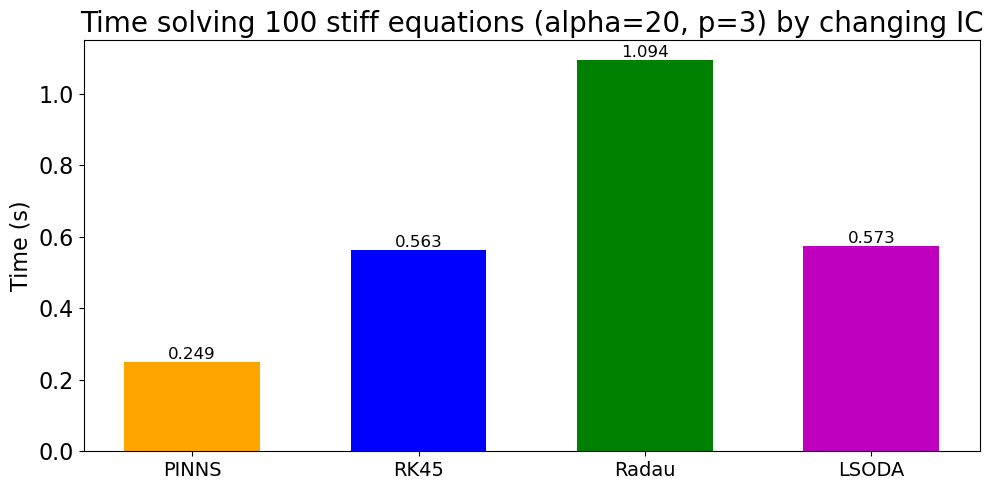

In [15]:
color = {"PINNS": 'orange', "RK45": 'b', "Radau": 'g', 'LSODA': 'm', "True": (1, 0, 0, 0.5)}
fig, ax = plt.subplots(1, tight_layout=True, figsize=(10, 5))

width = 0.6

for i, (method, compt_time) in enumerate(computational_time.items()):
    ax.bar(i, sum(compt_time), width=width, color=color[method],  label=f"{method} ")
    ax.annotate(f'{sum(compt_time):0.3f}', (i, sum(compt_time)), ha='center', va='bottom', fontsize=12)
# ax.set_yscale("log")
change_title = "IC and force" if (change_force and change_IC) else ("force" if change_force else "IC")
ax.set_title(f"Time solving {nb_transfer_equation} stiff equations (alpha={alpha_transfer}, p={p}) by changing {change_title}", fontsize=20)
ax.set_ylabel('Time (s)', fontsize=16)
ax.set_xticks([i for i in range(len(computational_time))], computational_time.keys())
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=16)
fig.tight_layout()